In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
import cv2
import numpy as np

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(total, activation='sigmoid'), #need to adjust total input nodes
      layers.Reshape((width, width)) #need to adjust width
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def plotimgs(original,encoded,reconstructed):
    #plot images
    fig, (ax1, ax2, ax3)=plt.subplots(ncols=3,figsize=(15,15))

    ax1.imshow(original,cmap='gray')
    ax2.imshow(encoded,cmap='gray')
    ax3.imshow(reconstructed,cmap='gray')

    ax1.title.set_text('Original')
    ax2.title.set_text('Compressed Encoded Image')
    ax3.title.set_text('Reconstructed Image')

# Getting Data

In [2]:
#Getting training and testing data
directory='./images/benign' #benign or malicious
files=[filename for filename in os.listdir(directory)]
x=[]
for index,file in enumerate(files):
    temp=np.load(directory+'/'+file)
    temp=np.reshape(temp,(648,648))
    x.append(temp)
    if index==999:
        break
trainsize=int(len(x)*(3/4))
x_train=x[:trainsize]
x_test=x[trainsize:]
x_train=np.array(x_train)
x_test=np.array(x_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


# Model & Image Parameters

In [3]:
width=648
total=width*width
reduced_dimension=64
reduced_width=int(reduced_dimension**(1/2))

# Method 1

In [4]:
#encoder
encoder_input = keras.Input(shape=(width,width,1),name='img')
x=keras.layers.Flatten()(encoder_input)
encoder_output=keras.layers.Dense(reduced_dimension,activation='relu')(x)
encoder=keras.Model(encoder_input,encoder_output,name='encoder')

#decoder
decoder_input=keras.layers.Dense(width*width,activation='relu')(encoder_output)
decoder_output=keras.layers.Reshape((width,width,1))(decoder_input)

#optimizer
opt=keras.optimizers.Adam(learning_rate=0.001,decay=1e-6)

autoencoder=keras.Model(encoder_input,decoder_output,name='autoencoder')
autoencoder.compile(opt,loss="mse")
autoencoder.fit(x_train,x_train, epochs=3,batch_size=32,validation_data=(x_test,x_test),validation_split=0.1)

Epoch 1/3
22/22 [==============================] - 6s 232ms/step - loss: 0.0549 - val_loss: 0.0242
Epoch 2/3
22/22 [==============================] - 5s 229ms/step - loss: 0.0388 - val_loss: 0.0211
Epoch 3/3
22/22 [==============================] - 5s 230ms/step - loss: 0.0367 - val_loss: 0.0196


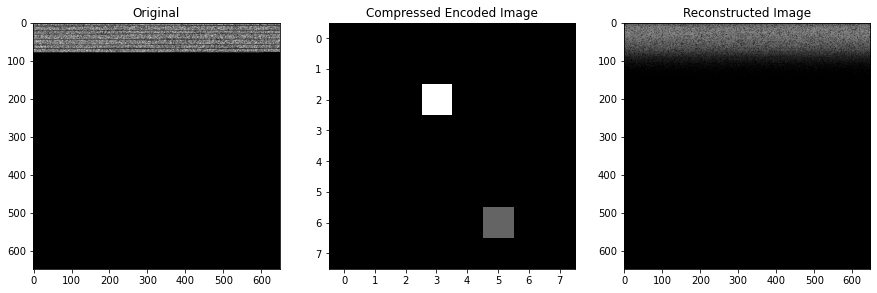

In [5]:
#encode test data
x_test_e=encoder.predict(x_test)

#encode and decode test data
x_test_ae=autoencoder.predict(x_test)

#plot images
plotimgs(x_test[0],x_test_e[0].reshape(reduced_width,reduced_width),x_test_ae[0])

# Method 2

In [6]:
autoencoder = Autoencoder(reduced_dimension)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,epochs=10,shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10
24/24 [==============================] - 7s 257ms/step - loss: 0.0804 - val_loss: 0.0526
Epoch 2/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0399 - val_loss: 0.0391
Epoch 3/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0266 - val_loss: 0.0246
Epoch 4/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0220 - val_loss: 0.0231
Epoch 5/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0200 - val_loss: 0.0220
Epoch 6/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0193 - val_loss: 0.0218
Epoch 7/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0193 - val_loss: 0.0215
Epoch 8/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0190 - val_loss: 0.0216
Epoch 9/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0189 - val_loss: 0.0215
Epoch 10/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0188 - val_loss: 0.0214

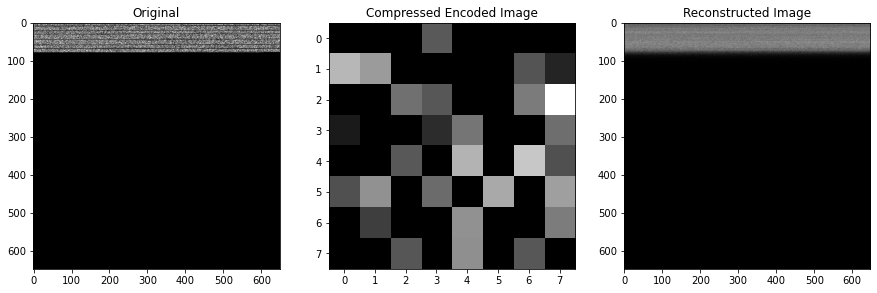

In [8]:
x_test_e=autoencoder.encoder(x_test).numpy()
x_test_ae=autoencoder.decoder(x_test_e).numpy()

#plot images
plotimgs(x_test[0],x_test_e[0].reshape(reduced_width,reduced_width),x_test_ae[0])